<a href="https://colab.research.google.com/github/CantDodgeCrap/IDA-ML-Feuer/blob/main/IDA_ML_Fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
# importing necessary tools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model, tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score

import requests
import io

In [2]:
# url of the data set on github

path = "https://raw.githubusercontent.com/CantDodgeCrap/IDA-ML-Feuer/main/fires.csv?token=GHSAT0AAAAAABZPU4FHUTURBTZ4UFIL5COEY2ETTKQ" 
download = requests.get(path).content

# loading data set into dataframe

df = pd.read_csv(io.StringIO(download.decode('utf-8')))
df

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [3]:
# overview of the data sets properties

print('The dataframe has the dimensions: ', df.shape)
print('It has the following properties: ', '\n\n')
print(df.info())

The dataframe has the dimensions:  (517, 13)
It has the following properties:  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB
None


# Data pre-processing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a0ed45d10>,
      dtype=object)

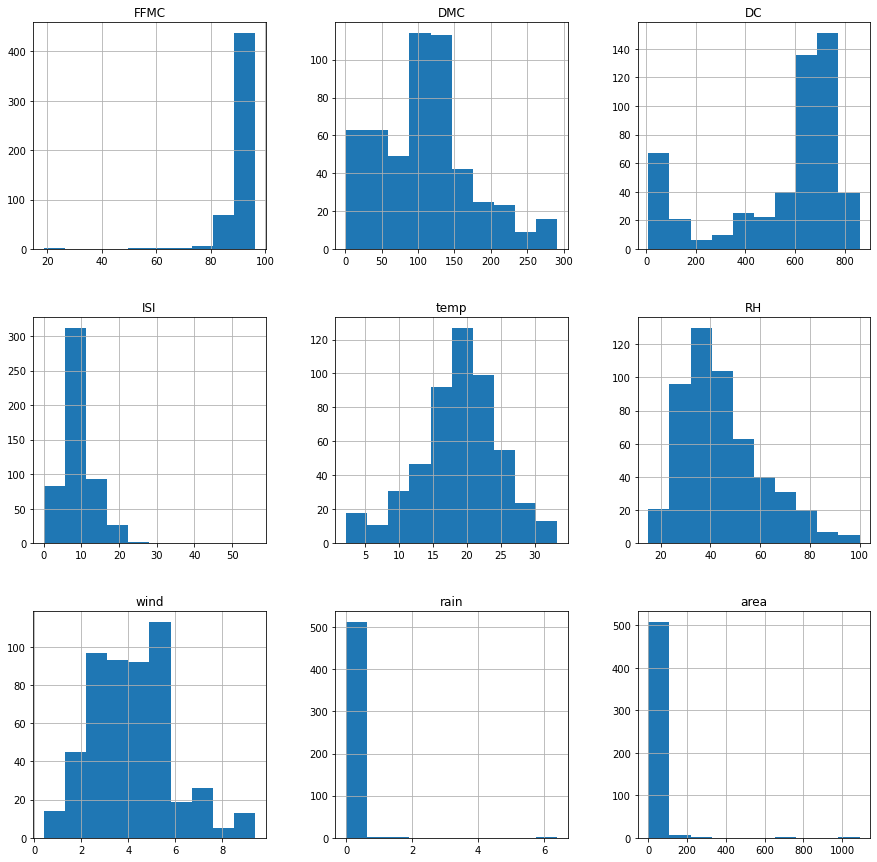

In [4]:
# the assignment advised transforming uneven distributed attributes like "area"
# it seems therefore useful to check other columns too by checking their histograms

df.hist(column = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain','area'], figsize=(15,15))

In [5]:
# transforming the "area" attribute

df['area_trans'] = np.log(1 + df['area'])
df[['area', 'area_trans']]

,area,area_trans
0,0.00,0.000000
1,0.00,0.000000
2,0.00,0.000000
3,0.00,0.000000
4,0.00,0.000000
...,...,...
512,6.44,2.006871
513,54.29,4.012592
514,11.16,2.498152
515,0.00,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a0edd7c10>,
      dtype=object)

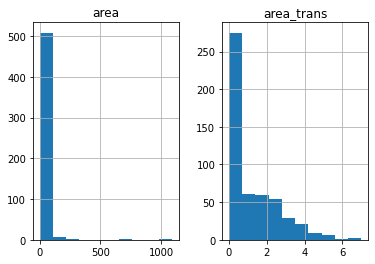

In [6]:
# comparison of the old and new columns

df.hist(column = ['area', 'area_trans'])

In [7]:
# dropping the original (pre-transformed) column

df = df.drop(['area'], axis = 1)

In [8]:
# checking if other attributes can be densed up too

df['rain_trans'] = np.log(1 + df['rain'])
df[['rain', 'rain_trans']]

,rain,rain_trans
0,0.0,0.000000
1,0.0,0.000000
2,0.0,0.000000
3,0.2,0.182322
4,0.0,0.000000
...,...,...
512,0.0,0.000000
513,0.0,0.000000
514,0.0,0.000000
515,0.0,0.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a0e2c8790>,
      dtype=object)

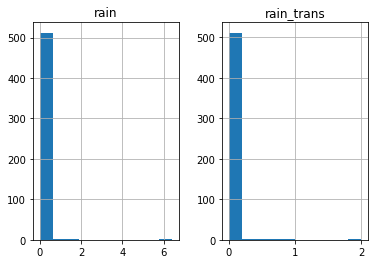

In [9]:
# no changes since values were in the same range already

df.hist(column = ['rain', 'rain_trans'])

In [10]:
# dropping the unnecessary transformed data

df = df.drop(['rain_trans'], axis = 1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a0f4a81d0>,
      dtype=object)

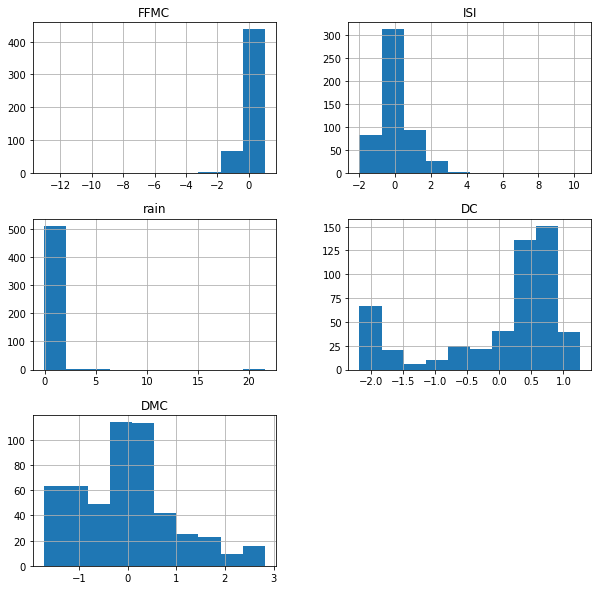

In [11]:
# testing any irregularities when it comes too outliers
# performing Z-Score Normalization

df_unnormal = df[['FFMC', 'ISI', 'rain','DC', 'DMC']]

dfz = (df_unnormal - df_unnormal.mean()) / df_unnormal.std()
dfz.hist(figsize=(10,10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a0df01550>,
      dtype=object)

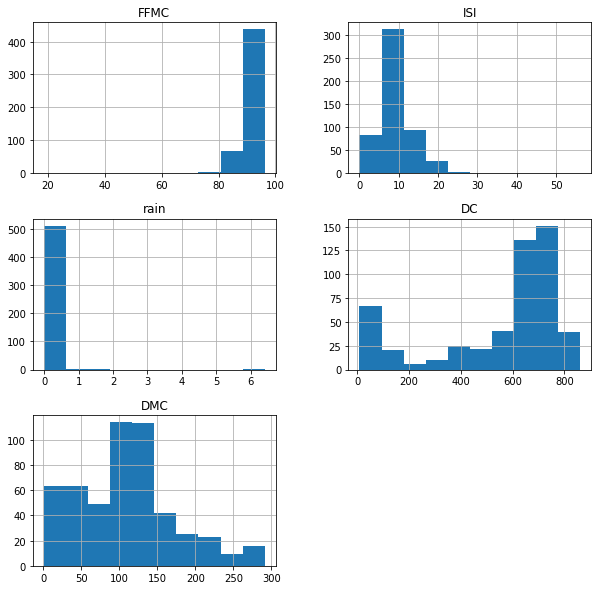

In [12]:
# as expected no changes because the diagrams did not give a hint on outliers in the first place (which Z-score Nomalization can spot and flat out)

df.hist(column = ['FFMC', 'ISI', 'rain','DC', 'DMC'], figsize=(10,10))

In [13]:
# the next four cells represent the effort of transforming the "day" and "month" column into numerical values for processing
# but since the date is just metadata of a row it does not influence the target value, the idea was scraped (saved the code for visualization of the thought process)

#df['month'].unique()

In [14]:
#df['day'].unique()

In [15]:
# dict_month = {'jan': 1,
#               'feb': 2,
#               'mar': 3,
#               'apr': 4,
#               'may': 5,
#               'jun': 6,
#               'jul': 7,
#               'aug': 8,
#               'sep': 9,
#               'oct': 10,
#               'nov': 11,
#               'dec': 12}
# df = df.replace({"month": dict_month})              

In [16]:
# dict_day = {'mon': 1,
#             'tue': 2,
#             'wed': 3,
#             'thu': 4,
#             'fri': 5,
#             'sat': 6,
#             'sun': 7}
# df = df.replace({"day": dict_day}) 

In [17]:
# Summing up all possible NA- and NULL-values in the data set

na_values = df.isna().values.sum()
null_values = df.isnull().values.sum()

print('There is/are', na_values ,"N/A value(s) in the given dataset.")
print('There is/are', null_values ,"NULL value(s) in the given dataset.")
# none are found, therefor nothing needs to be done 

There is/are 0 N/A value(s) in the given dataset.
There is/are 0 NULL value(s) in the given dataset.


In [18]:
# removing the columns that contain metadata, which does't contibute to the target variable

df = df.drop(['day', 'month', 'X', 'Y'], axis=1)
df

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area_trans
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.000000
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.000000
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.000000
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.000000
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
512,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,2.006871
513,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,4.012592
514,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,2.498152
515,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.000000


# Set up data split

In [19]:
# the dependent target value ("area" attribute) gets separeted from the rest
# both sets become their own numpy array

fire_data = df.values[::1,:8]
fire_target = df.values[::1,8]

In [20]:
# displaying the values of the independent attributes

fire_data

array([[ 86.2,  26.2,  94.3, ...,  51. ,   6.7,   0. ],
       [ 90.6,  35.4, 669.1, ...,  33. ,   0.9,   0. ],
       [ 90.6,  43.7, 686.9, ...,  33. ,   1.3,   0. ],
       ...,
       [ 81.6,  56.7, 665.6, ...,  70. ,   6.7,   0. ],
       [ 94.4, 146. , 614.7, ...,  42. ,   4. ,   0. ],
       [ 79.5,   3. , 106.7, ...,  31. ,   4.5,   0. ]])

In [21]:
# displaying the values of the dependent attribute

fire_target

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [22]:
# creation of a function that can split both arrays of independent (data) and dependent (target) variables in to a test and training set while keeping a given ratio and seed

def test_train_split(data,target,ratio,seed):
  #set the random seed
  np.random.seed(seed)

  # estasblish a randomized order
  order = np.arange(len(data))
  np.random.shuffle(order)
  # assigning the suffeld order to either array
  x = (np.array(data, dtype=object)[order])
  y = (np.array(target, dtype=object)[order])

  # split the data and target values into train and test sets given the set ratio
  split_index = int(len(x) * ratio)

  data_train = x[:split_index]
  data_test = x[split_index:]
  target_train = y[:split_index]
  target_test = y[split_index:]

  return data_train, data_test, target_train, target_test

In [23]:
# calling the above function with the variables of choice

data = fire_data
target = fire_target
ratio = 0.85
seed = 69

data_train, data_test, target_train, target_test = test_train_split(data,target,ratio,seed)

In [24]:
# displaying the shape of the functions outcome

data_train.shape, data_test.shape, target_train.shape, target_test.shape

((439, 8), (78, 8), (439,), (78,))

# Model training and data prediction

In [25]:
# function that accepts one model type and fits it to the data
# output is the fitted model
# Multiple Linear Regression is the easiest approach for finding the value of a dependent variable at a certain value of two or more independent variables
# "LinearRegression()" from Scikit Learn works for more than one variable too

def train_model(model):
  if model == "linear":
    clf = linear_model.LinearRegression()
    clf = clf.fit(data_train, target_train)
  elif model == "tree":
    clf = tree.DecisionTreeRegressor()
    clf = clf.fit(data_train, target_train)
  else:
      print('Model not found')

  return clf

In [26]:
# predicting values with the help of the choosen model

model = "linear"
target_pred = train_model(model).predict(data_test)

# Evaluation

In [27]:
# three standard functions for evaluating a models performance

def mean_abs_error(target_true,target_pred):
    
    return np.mean(np.abs(target_true - target_pred))


def mean_sqrt_error(target_true,target_pred):
    
    return np.mean(np.square(target_true - target_pred))


def root_mean_sqrt_error(target_true,target_pred):
    
    return np.sqrt(np.mean(np.square(target_true - target_pred)))

In [28]:
# evaluation results for the trained model

print('The model', '("', model, '")', 'has a Mean Absolute Error (MAE) of:', mean_abs_error(target_test,target_pred))
print('The model', '("', model, '")', 'has a Mean Squared Error (MSE) of:', mean_sqrt_error(target_test,target_pred))
print('The model', '("', model, '")', 'has a Root Mean Squared Error (RMSE) of:', root_mean_sqrt_error(target_test,target_pred))

# With a slightly lower RMSE the Multiple Linear Regression algortithm performs better

The model (" linear ") has a Mean Absolute Error (MAE) of: 0.9642323361185364
The model (" linear ") has a Mean Squared Error (MSE) of: 1.1831865692884382
The model (" linear ") has a Root Mean Squared Error (RMSE) of: 1.0877437976327138


In [29]:
# additional information in case of the linear model

print('After fitting the model the coefficients became:', train_model(model).coef_)
print('The intercept is:', train_model(model).intercept_)

After fitting the model the coefficients became: [ 0.00926659  0.00111749  0.00013374 -0.02529756  0.01519875 -0.00291458
  0.07410151  0.06105737]
The intercept is: -0.10874514695545878
